In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from bmadx.plot import plot_projections
from bmadx.pmd_utils import openpmd_to_bmadx_beam, bmadx_beam_to_openpmd
from phase_space_reconstruction.analysis import screen_stats, get_beam_fraction_bmadx_beam, get_beam_fraction_bmadx_particle

In [2]:
data_dir = os.path.join('data', 'gaussian_beam')
t_scan_dir = os.path.join(data_dir, 't_scan')
n_par_dir = os.path.join(data_dir, 'n_par')

# Number of particles study

In [3]:
# ground truth beam:
gt =  torch.load(os.path.join(n_par_dir, 'non_gaussian_beam.pt')).numpy_particles()
# reconstructions:
r_1e4 = torch.load(os.path.join(n_par_dir, '3D_scan_10_000.pt')).numpy_particles()
r_1e5 = torch.load(os.path.join(n_par_dir, '3D_scan_100_000.pt')).numpy_particles()
r_1e6 = torch.load(os.path.join(n_par_dir, '3D_scan_1_000_000.pt')).numpy_particles()
np.shape(np.stack(gt[:6]))

(6, 1000000)

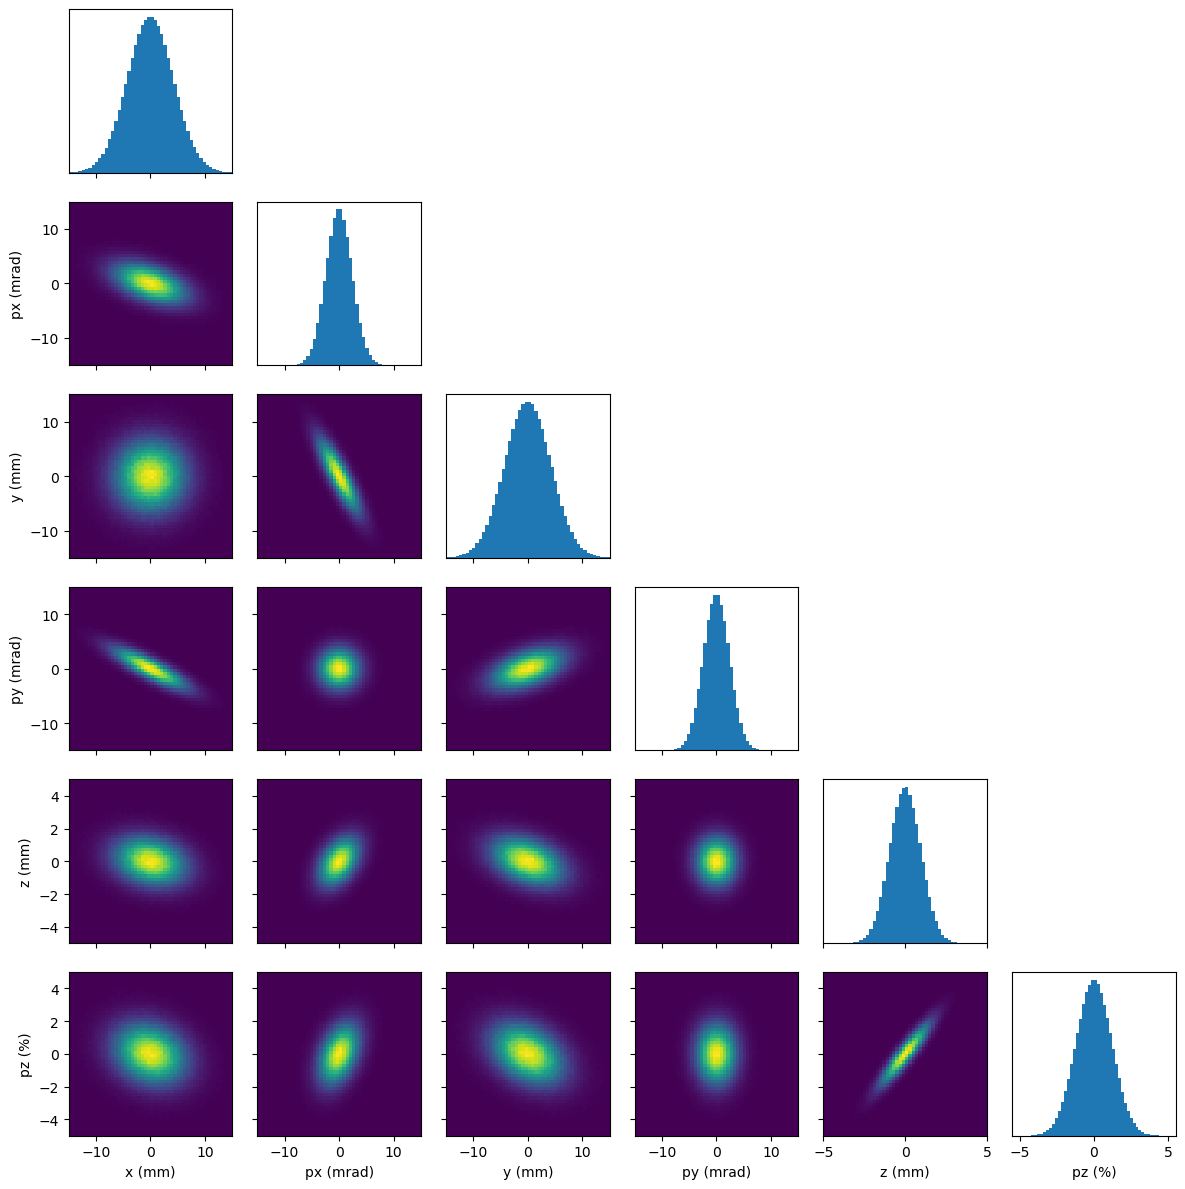

In [4]:
# plot gt:
lims = np.array([
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-15e-3,15e-3],
    [-5e-3,5e-3],
    [-5e-2,5e-2]
])
plot_projections(gt, custom_lims=lims)
plt.show()

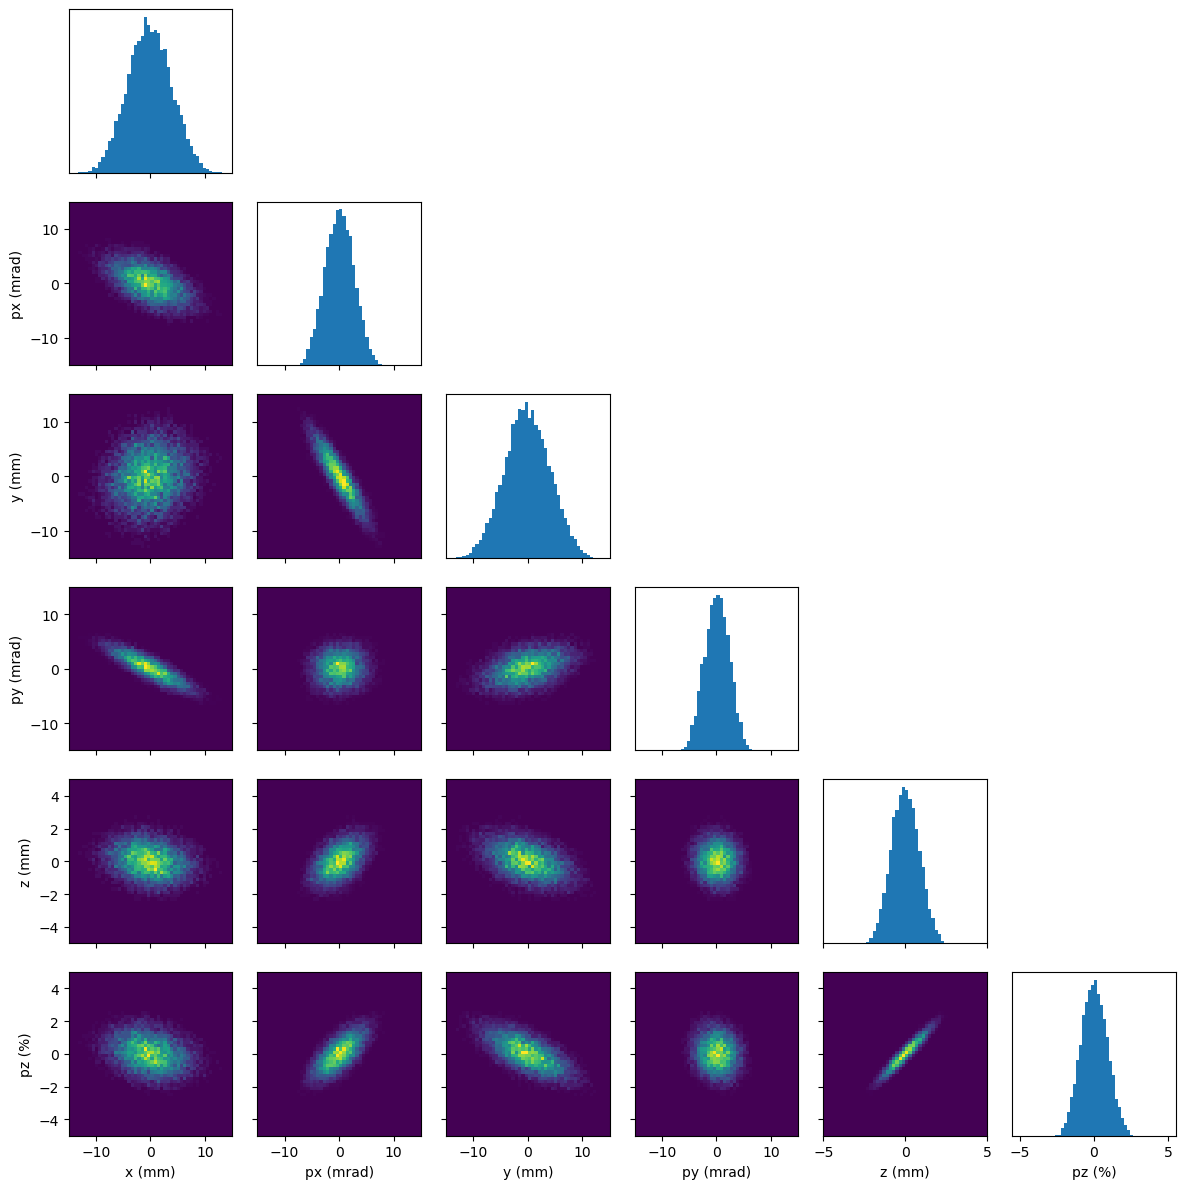

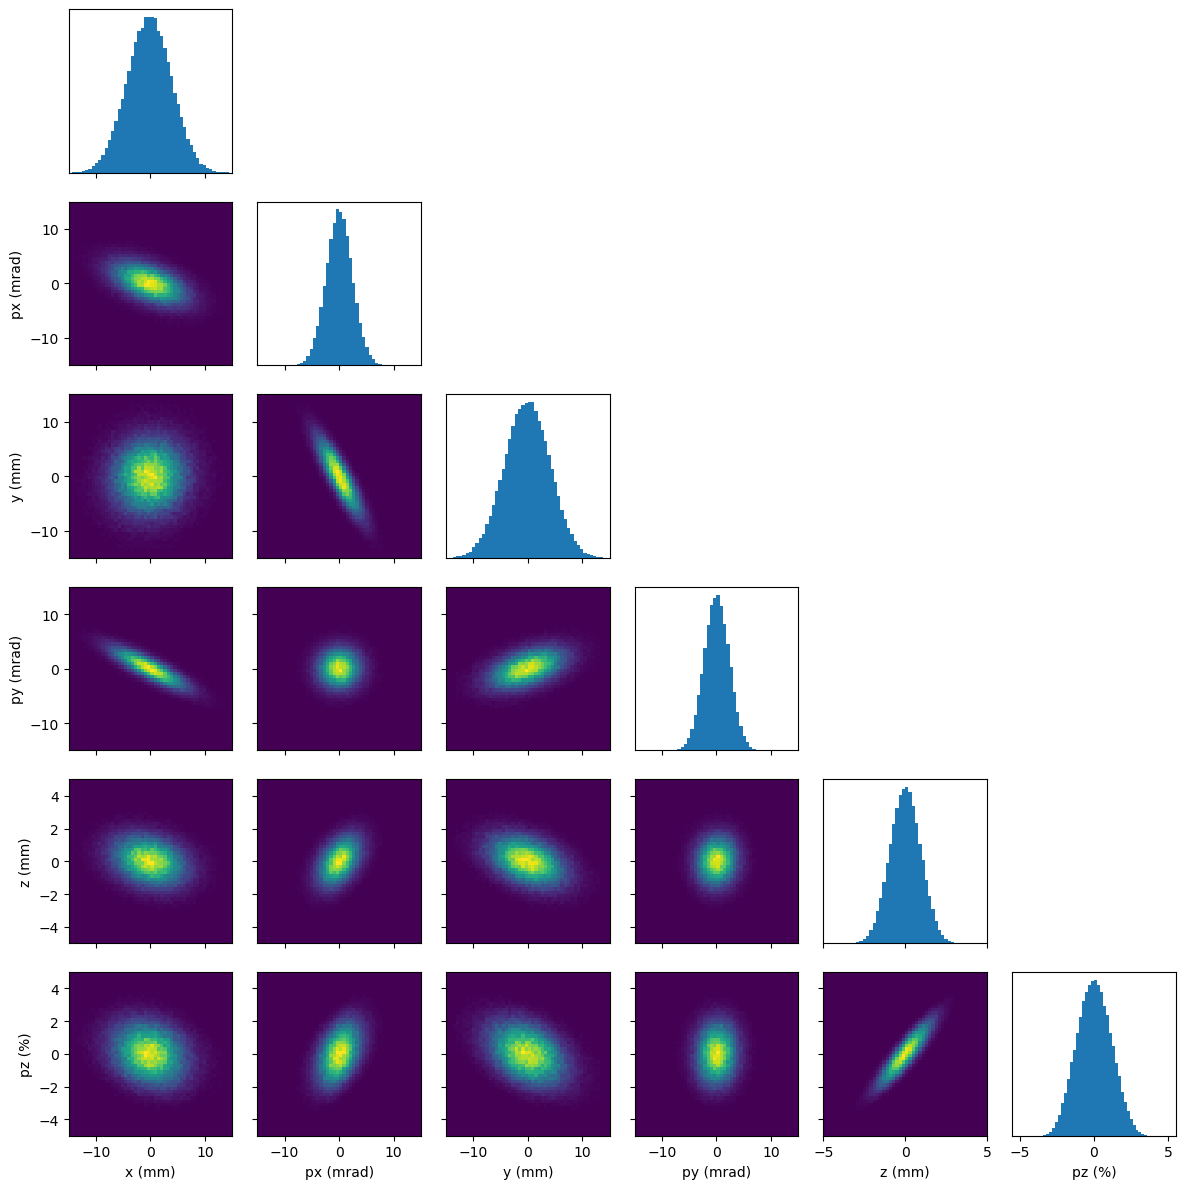

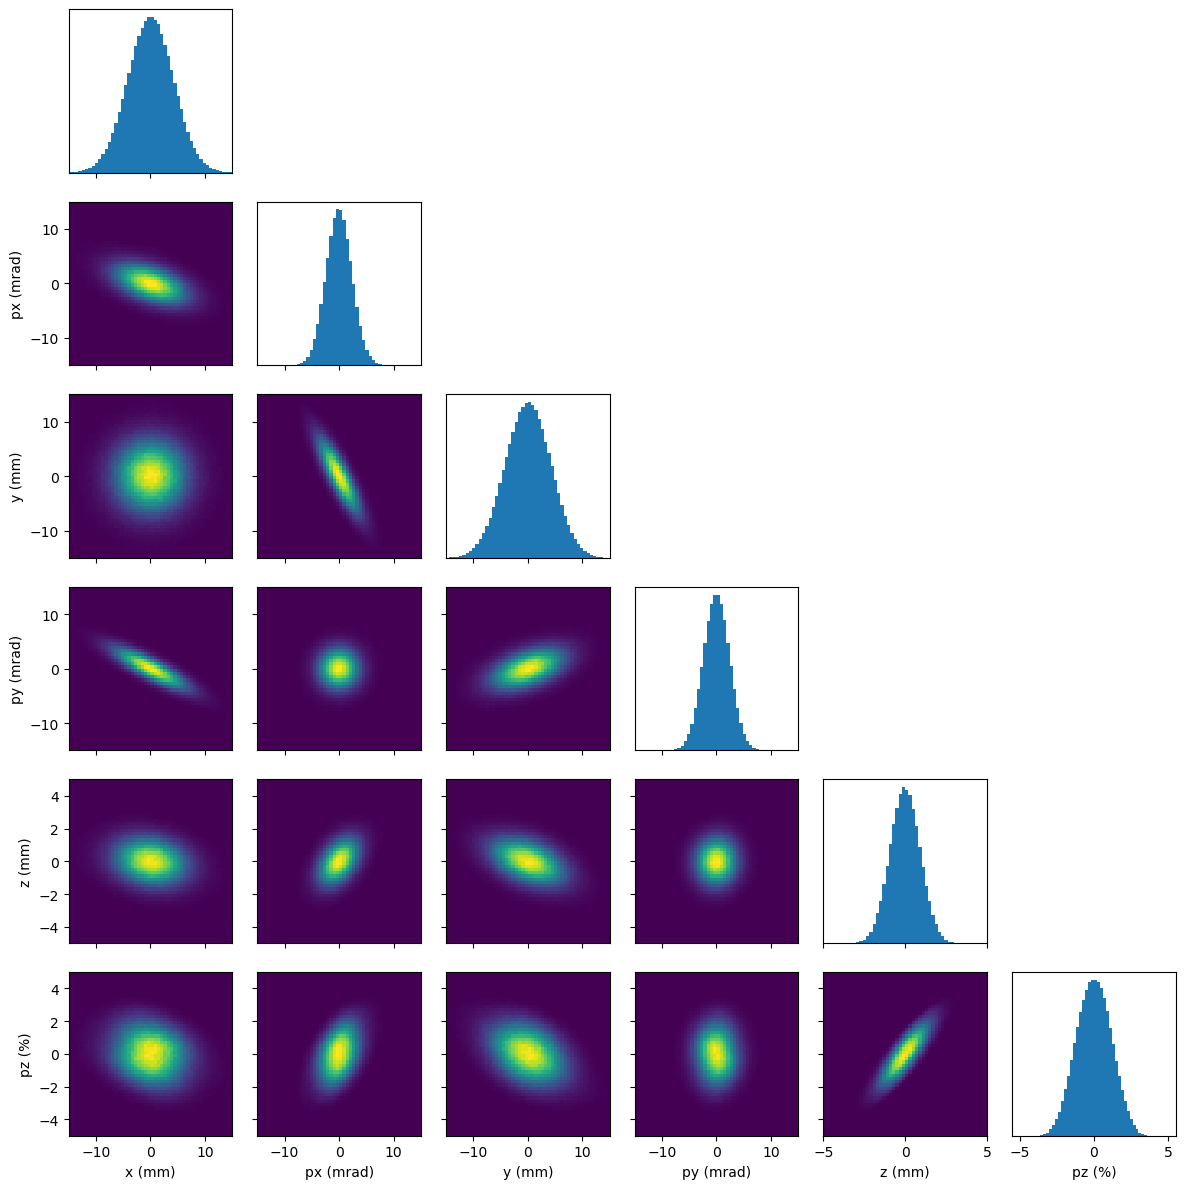

In [5]:
# plot recontructions:
plot_projections(r_1e4, custom_lims=lims)
plt.show()
plot_projections(r_1e5, custom_lims=lims)
plt.show()
plot_projections(r_1e6, custom_lims=lims)
plt.show()

In [6]:
#gt_frac_50 = get_beam_fraction_from_projection(gt, ('y','py'),0.5)
gt_frac_50 = get_beam_fraction_bmadx_particle(gt, 0.5)
gt_frac_90 = get_beam_fraction_bmadx_particle(gt, 0.9)
gt_frac_95 = get_beam_fraction_bmadx_particle(gt, 0.95)
print(len(gt_frac_50.x))
print(len(gt_frac_90.x))
print(len(gt_frac_95.x))

500000
900000
950000


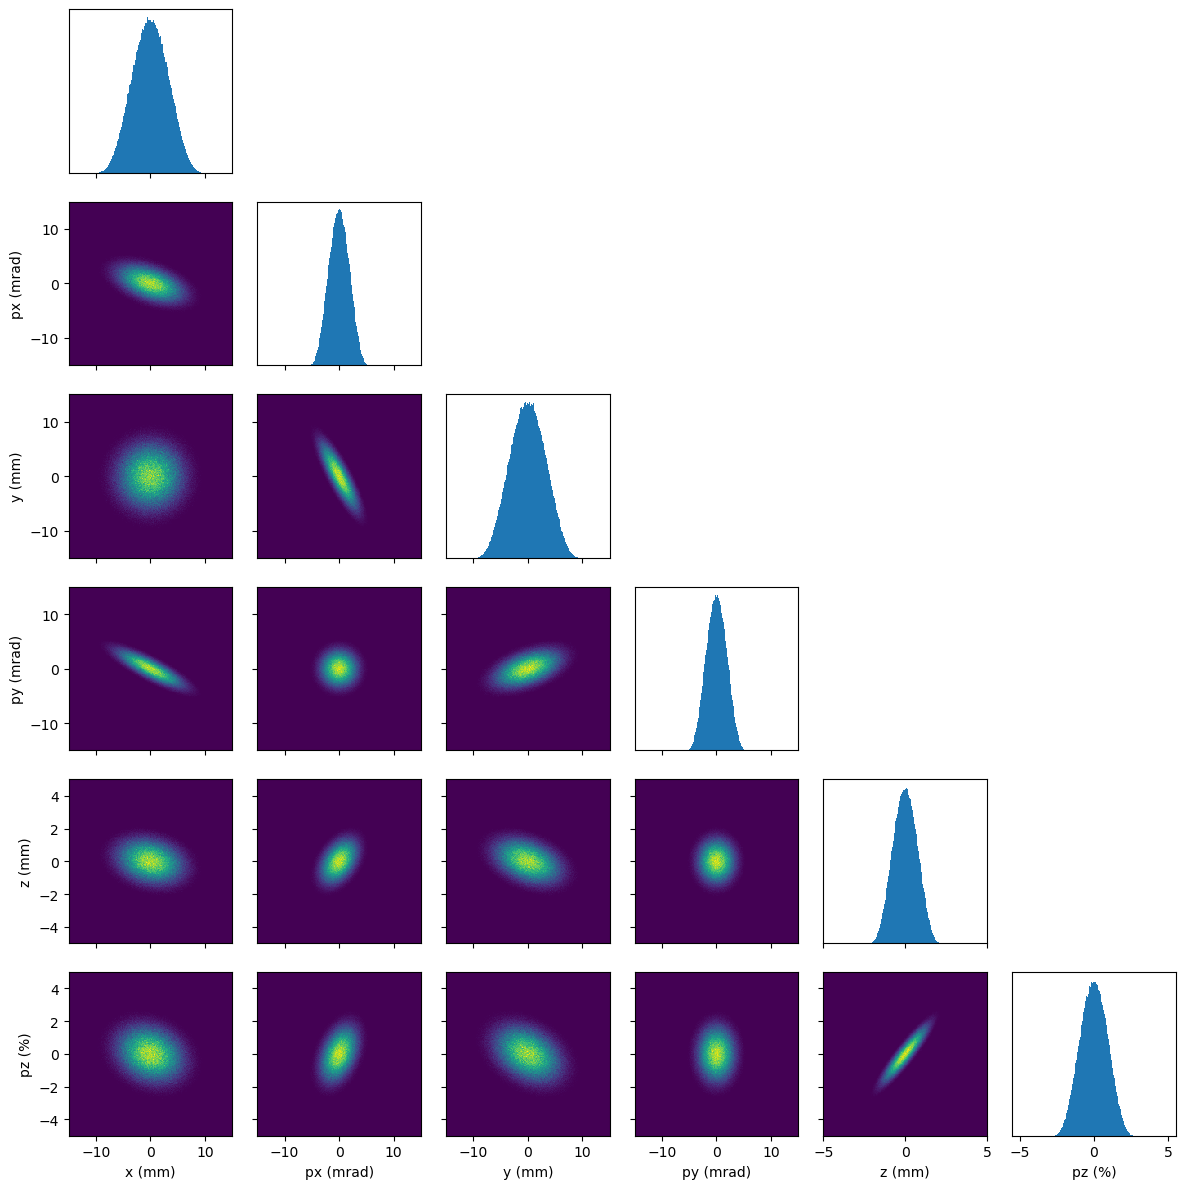

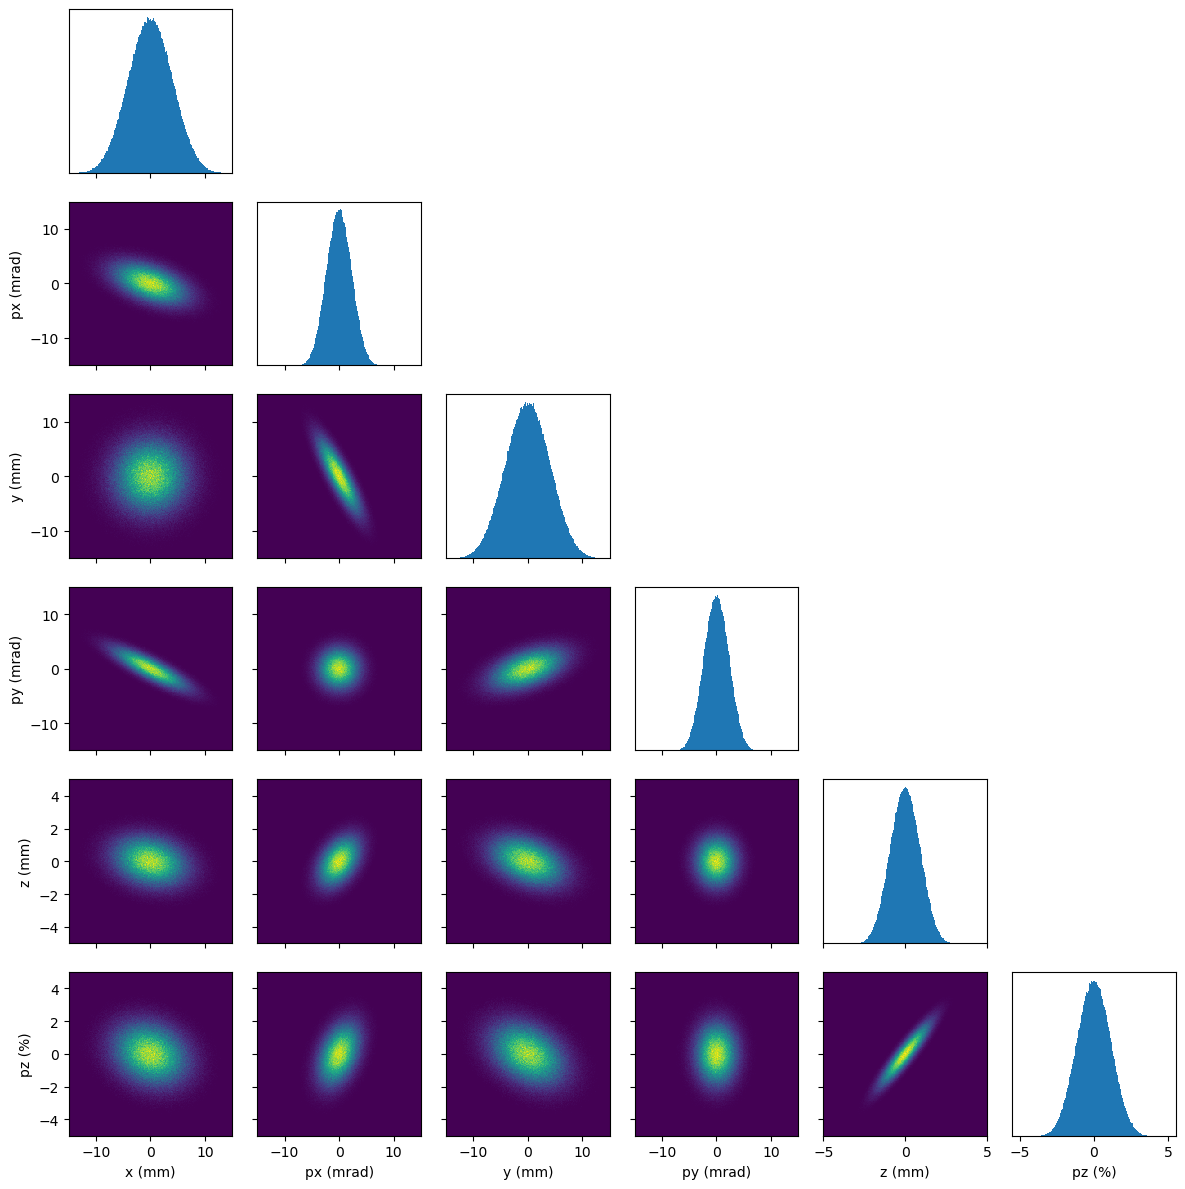

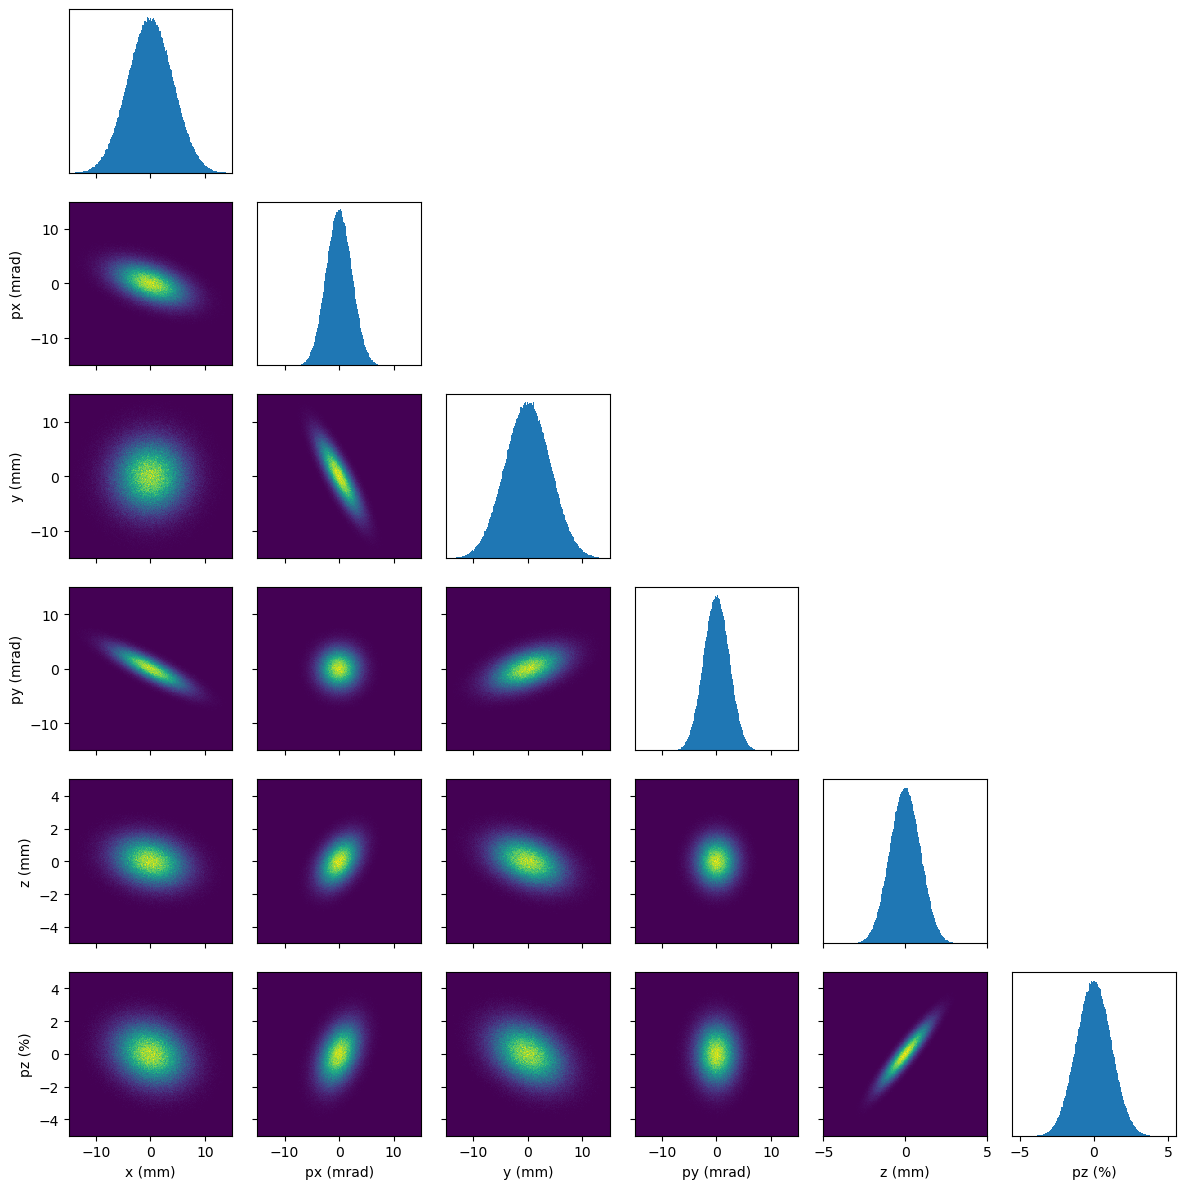

In [7]:
plot_projections(gt_frac_50, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_90, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_95, custom_lims=lims, bins=200)
plt.show()

In [8]:
from scipy.ndimage import gaussian_filter
from bmadx.structures import Particle

def get_beam_fraction_from_projection(
        beam_distribution: Particle,
        axes: list,
        beam_fraction: float
):
    """ get core of the beam according to 6D normalized beam coordinates"""
    full_coords = np.stack(beam_distribution[:6]).T
    data = np.copy(np.stack([getattr(beam_distribution, ax) for ax in axes]).T)
    cov = np.cov(data.T)

    # get inverse cholesky decomp
    t_data = (np.linalg.inv(np.linalg.cholesky(cov)) @ data.T).T

    J = np.linalg.norm(t_data, axis=1)
    sort_idx = np.argsort(J)
    frac_coords = full_coords[sort_idx][:int(len(full_coords) * beam_fraction)]
    frac_particle = Particle(
        *frac_coords.T,
        p0c = beam_distribution.p0c,
        s = beam_distribution.s,
        mc2 = beam_distribution.mc2
    )

    return frac_particle

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

def plot_projections_with_contours(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing_r = 1,
        contour_smoothing_gt = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size, dpi=300)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)

    for i in range(n_coords):
        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale

        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
        )
        
        ax[i,i].yaxis.set_tick_params(left=False, labelleft=False)

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):
            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            rng=[[min_x, max_x],[min_y, max_y]]
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range = rng,
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k, percentile in enumerate(contour_percentiles):
                #r_fractions = get_beam_fraction_from_projection(
                #        reconstruction, 
                #        [x_coord, y_coord],
                #        percentile/100
                #)

                #h_r_fractions, _, _ = np.histogram2d(
                #    getattr(r_fractions, x_coord)*scale,
                #    getattr(r_fractions, y_coord)*scale,
                #    bins = bins,
                #    range = rng
                #)
                h_r_fractions = get_beam_fraction_hist2d(hist, percentile/100)
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                    #h_r_fractions.T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    #gt_fractions = get_beam_fraction_from_projection(
                    #        ground_truth, 
                    #        [x_coord, y_coord],
                    #        percentile/100
                    #)

                    #h_gt_fractions, _, _ = np.histogram2d(
                    #    getattr(gt_fractions, x_coord)*scale,
                    #    getattr(gt_fractions, y_coord)*scale,
                    #    bins = bins,
                    #    range = rng
                    #)
                    h_gt, _, _ = np.histogram2d(
                        getattr(ground_truth, x_coord)*scale,
                        getattr(ground_truth, y_coord)*scale,
                        bins = bins,
                        range = rng
                    )
                    h_gt_fractions = get_beam_fraction_hist2d(h_gt, percentile/100)

                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        #h_gt_fractions.T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )  



            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])
            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


def plot_projections_with_contours2(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing_r = 1,
        contour_smoothing_gt = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)


    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    gt_fractions = []
    r_fractions = []
    for percentile in contour_percentiles:
        r_fractions.append(
            get_beam_fraction_from_projection(
                reconstruction, 
                ('x', 'px', 'y', 'py', 'z', 'pz'),
                percentile/100)
        )

        if ground_truth is not None:
            gt_fractions.append(
                get_beam_fraction_from_projection(
                    ground_truth, 
                    ('x', 'px', 'y', 'py', 'z', 'pz'),
                    percentile/100)
            )
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)
    for i in range(n_coords):

        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale
        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
            )
        
        ax[i,i].yaxis.set_tick_params(
            left=False, 
            labelleft=False
            )

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):

            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range=[[min_x, max_x],
                        [min_y, max_y]],
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k in range(n_contours):
                
                h_r_fractions, _, _ = np.histogram2d(
                    getattr(r_fractions[k], x_coord)*scale,
                    getattr(r_fractions[k], y_coord)*scale,
                    bins = bins,
                    range = [[min_x, max_x],[min_y, max_y]]
                )

                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing_r).T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    h_gt_fractions, _, _ = np.histogram2d(
                        getattr(gt_fractions[k], x_coord)*scale,
                        getattr(gt_fractions[k], y_coord)*scale,
                        bins = bins,
                        range = [[min_x, max_x],[min_y, max_y]]
                    )
                    
                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing_gt).T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )
                    

            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])

            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


6


/tmp/ipykernel_18475/2807903281.py:209: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


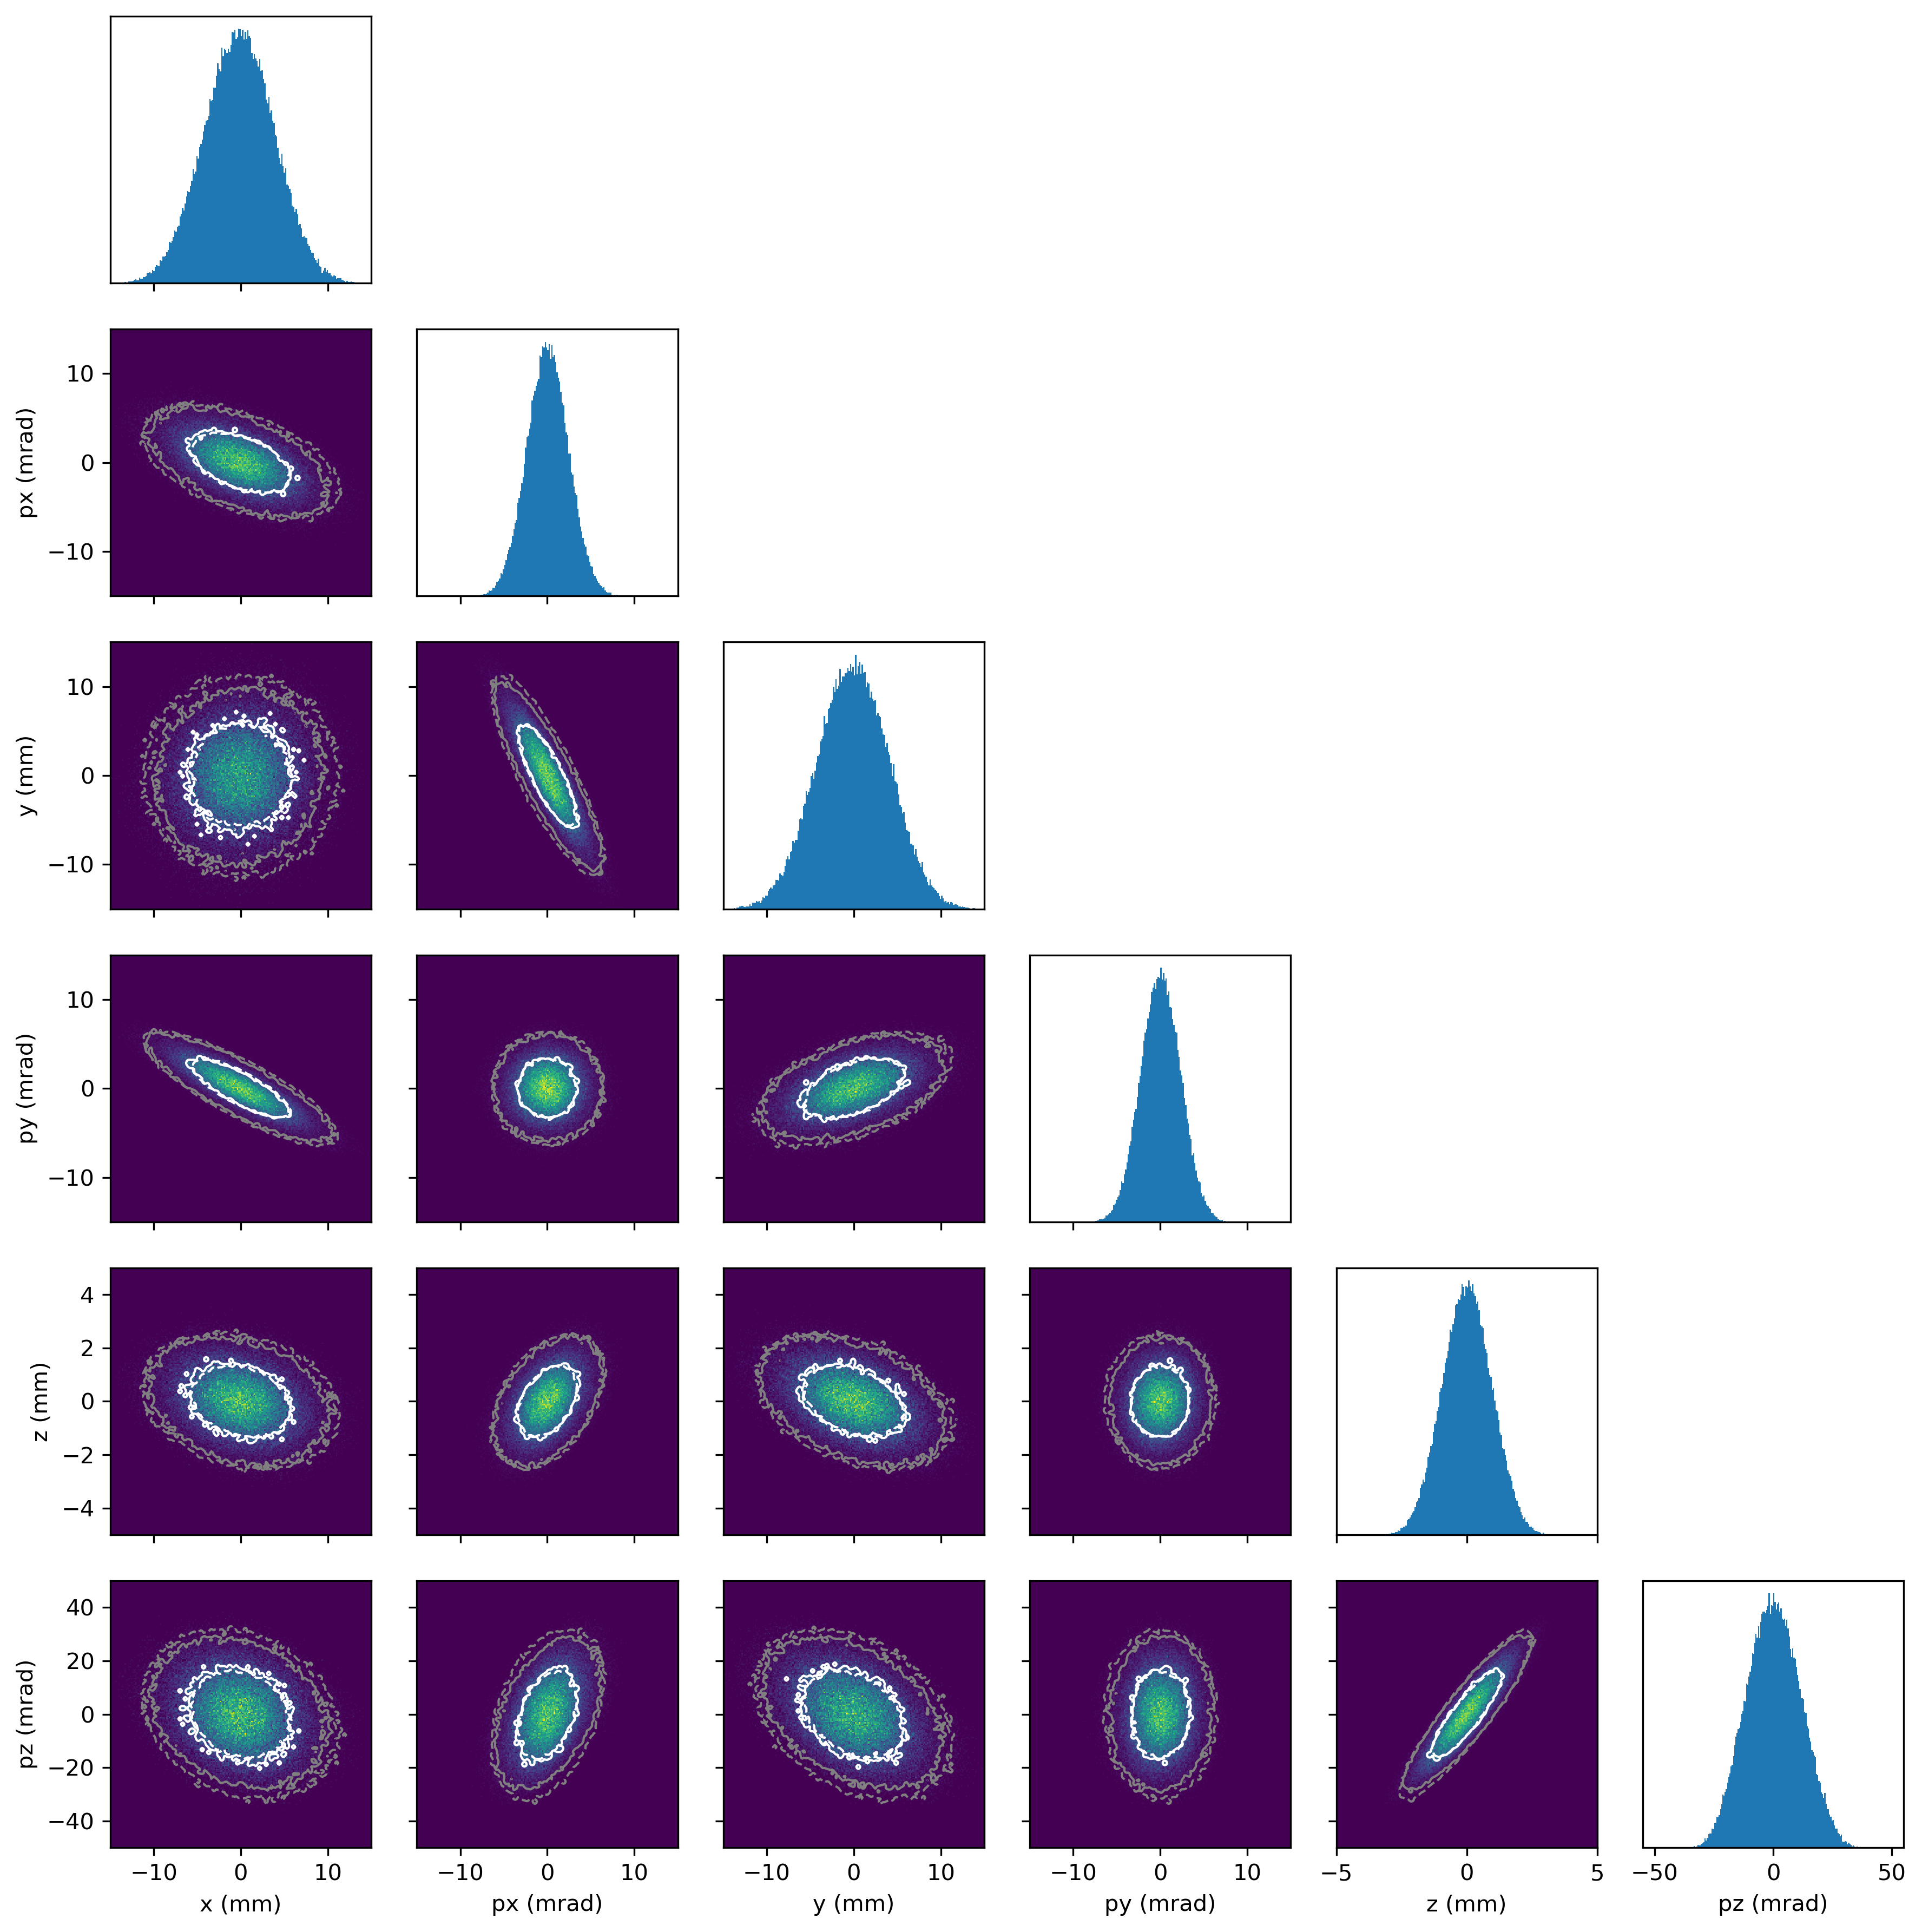

In [9]:
plot_projections_with_contours(
    r_1e5,
    gt,
    bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=1,
    contour_smoothing_gt=1
)
plt.show()

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(np.cov(r_1e4[:6])*1e6)
print(np.cov(r_1e5[:6])*1e6)
print(np.cov(r_1e6[:6])*1e6)
print(np.cov(gt[:6])*1e6)

[[15.634 -5.502 1.897 -7.545 -0.687 -9.055]
 [-5.502 6.739 -9.581 0.224 1.007 15.388]
 [1.897 -9.581 16.784 3.607 -1.492 -23.713]
 [-7.545 0.224 3.607 4.884 -0.080 -2.069]
 [-0.687 1.007 -1.492 -0.080 0.689 6.840]
 [-9.055 15.388 -23.713 -2.069 6.840 74.305]]
[[16.320 -5.063 0.783 -7.851 -0.923 -9.523]
 [-5.063 5.707 -8.570 0.059 0.991 11.700]
 [0.783 -8.570 17.132 4.454 -1.554 -17.912]
 [-7.851 0.059 4.454 5.181 0.109 1.142]
 [-0.923 0.991 -1.554 0.109 0.876 9.542]
 [-9.523 11.700 -17.912 1.142 9.542 128.440]]
[[17.573 -4.987 0.006 -8.526 -0.701 -9.164]
 [-4.987 5.552 -8.388 0.026 0.954 11.739]
 [0.006 -8.388 17.549 4.902 -1.702 -18.509]
 [-8.526 0.026 4.902 5.697 0.080 -0.408]
 [-0.701 0.954 -1.702 0.080 0.830 8.948]
 [-9.164 11.739 -18.509 -0.408 8.948 132.130]]
[[18.010 -5.005 0.006 -8.665 -0.877 -10.131]
 [-5.005 5.779 -8.657 0.006 0.976 11.249]
 [0.006 -8.657 17.990 4.991 -1.523 -17.536]
 [-8.665 0.006 4.991 5.778 -0.001 0.005]
 [-0.877 0.976 -1.523 -0.001 0.913 10.525]
 [-10.131

In [11]:
print((np.cov(r_1e4[:6])-np.cov(gt[:6]))*1e6)
print((np.cov(r_1e5[:6])-np.cov(gt[:6]))*1e6)
print((np.cov(r_1e6[:6])-np.cov(gt[:6]))*1e6)

[[-2.376 -0.497 1.892 1.120 0.190 1.076]
 [-0.497 0.960 -0.924 0.218 0.031 4.139]
 [1.892 -0.924 -1.206 -1.384 0.031 -6.177]
 [1.120 0.218 -1.384 -0.894 -0.079 -2.074]
 [0.190 0.031 0.031 -0.079 -0.224 -3.685]
 [1.076 4.139 -6.177 -2.074 -3.685 -68.347]]
[[-1.690 -0.058 0.777 0.815 -0.046 0.608]
 [-0.058 -0.072 0.087 0.053 0.015 0.451]
 [0.777 0.087 -0.858 -0.537 -0.031 -0.376]
 [0.815 0.053 -0.537 -0.598 0.110 1.137]
 [-0.046 0.015 -0.031 0.110 -0.037 -0.984]
 [0.608 0.451 -0.376 1.137 -0.984 -14.211]]
[[-0.437 0.019 0.000 0.139 0.175 0.966]
 [0.019 -0.226 0.269 0.021 -0.022 0.491]
 [0.000 0.269 -0.441 -0.089 -0.179 -0.973]
 [0.139 0.021 -0.089 -0.081 0.081 -0.413]
 [0.175 -0.022 -0.179 0.081 -0.083 -1.577]
 [0.966 0.491 -0.973 -0.413 -1.577 -10.522]]


In [12]:
print((np.cov(r_1e4[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))
print((np.cov(r_1e5[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))
print((np.cov(r_1e6[:6])-np.cov(gt[:6]))/np.cov(gt[:6]))

[[-0.132 0.099 331.179 -0.129 -0.216 -0.106]
 [0.099 0.166 0.107 39.218 0.031 0.368]
 [331.179 0.107 -0.067 -0.277 -0.020 0.352]
 [-0.129 39.218 -0.277 -0.155 73.303 -424.396]
 [-0.216 0.031 -0.020 73.303 -0.245 -0.350]
 [-0.106 0.368 0.352 -424.396 -0.350 -0.479]]
[[-0.094 0.012 136.011 -0.094 0.053 -0.060]
 [0.012 -0.012 -0.010 9.538 0.015 0.040]
 [136.011 -0.010 -0.048 -0.108 0.020 0.021]
 [-0.094 9.538 -0.108 -0.103 -102.701 232.782]
 [0.053 0.015 0.020 -102.701 -0.040 -0.093]
 [-0.060 0.040 0.021 232.782 -0.093 -0.100]]
[[-0.024 -0.004 0.078 -0.016 -0.200 -0.095]
 [-0.004 -0.039 -0.031 3.717 -0.023 0.044]
 [0.078 -0.031 -0.025 -0.018 0.118 0.055]
 [-0.016 3.717 -0.018 -0.014 -75.412 -84.576]
 [-0.200 -0.023 0.118 -75.412 -0.090 -0.150]
 [-0.095 0.044 0.055 -84.576 -0.150 -0.074]]


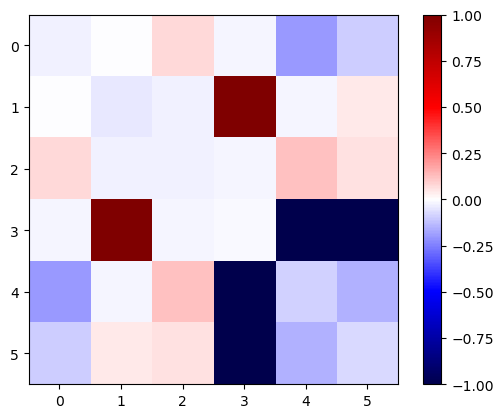

In [13]:
fig, ax = plt.subplots()
c = ax.imshow((np.cov(r_1e6[:6])-np.cov(gt[:6]))/np.cov(gt[:6]), cmap='seismic', vmin=-1, vmax=1)
fig.colorbar(c)

# 3D scan vs 'T' scan

In [14]:
gt_2 = torch.load(os.path.join(t_scan_dir, 'non_gaussian_beam.pt')).numpy_particles()
r_3d = torch.load(os.path.join(t_scan_dir, '3D_scan_100_000.pt')).numpy_particles()
r_t = torch.load(os.path.join(t_scan_dir, 't_scan_100_000.pt')).numpy_particles()

6


/tmp/ipykernel_18475/2807903281.py:209: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


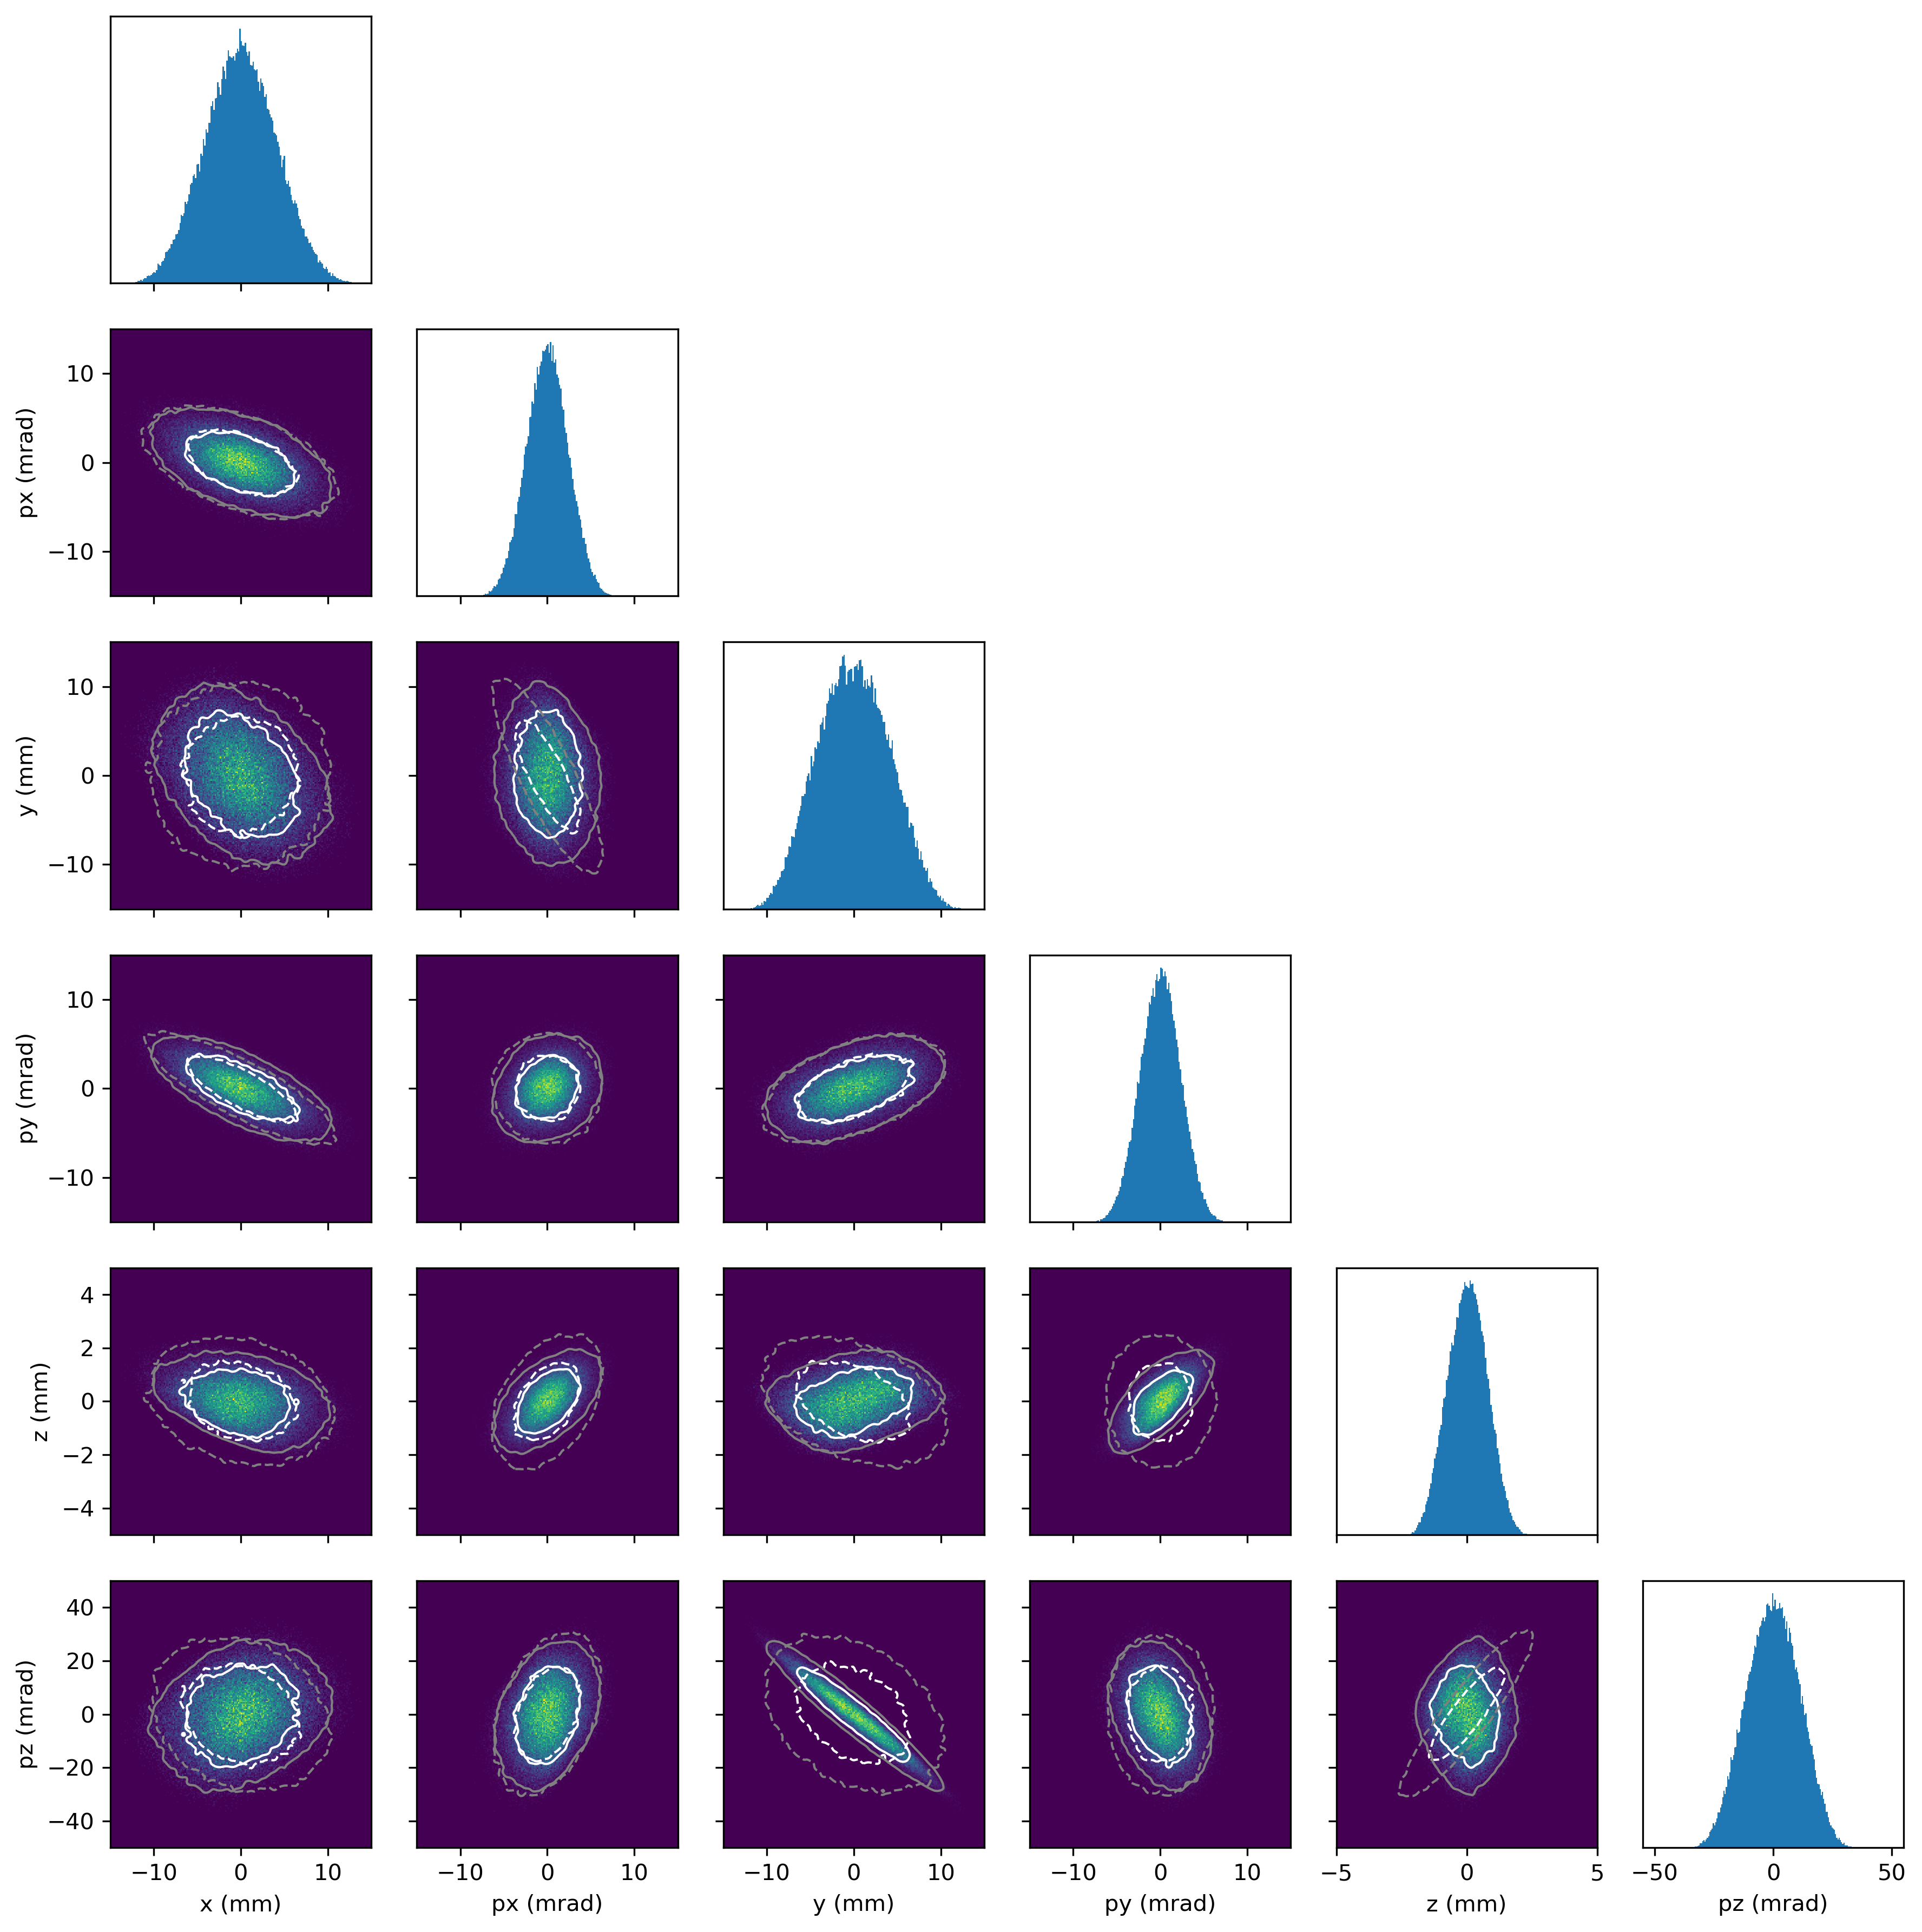

In [15]:
plot_projections_with_contours(
    r_t,
    gt_2,
    bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing_r=2,
    contour_smoothing_gt=2
)
plt.show()

In [16]:
print(np.cov(r_3d[:6])*1e6)
print(np.cov(r_t[:6])*1e6)
print(np.cov(gt_2[:6])*1e6)

[[17.113 -4.915 0.145 -8.355 -0.949 -9.215]
 [-4.915 5.558 -8.098 0.049 1.035 12.159]
 [0.145 -8.098 15.905 4.633 -1.505 -18.339]
 [-8.355 0.049 4.633 5.488 0.023 -0.692]
 [-0.949 1.035 -1.505 0.023 0.972 10.479]
 [-9.215 12.159 -18.339 -0.692 10.479 128.475]]
[[16.609 -4.547 -5.763 -6.502 -0.942 9.705]
 [-4.547 5.600 -0.795 1.173 0.966 7.659]
 [-5.763 -0.795 16.817 4.404 0.634 -44.217]
 [-6.502 1.173 4.404 5.256 1.181 -8.107]
 [-0.942 0.966 0.634 1.181 0.554 -0.084]
 [9.705 7.659 -44.217 -8.107 -0.084 123.834]]
[[17.923 -4.954 -0.044 -8.634 -0.873 -10.040]
 [-4.954 5.779 -8.687 -0.032 0.976 11.221]
 [-0.044 -8.687 18.077 5.046 -1.526 -17.538]
 [-8.634 -0.032 5.046 5.779 -0.003 -0.032]
 [-0.873 0.976 -1.526 -0.003 0.913 10.544]
 [-10.040 11.221 -17.538 -0.032 10.544 143.111]]


In [17]:
print((np.cov(r_3d[:6])-np.cov(gt_2[:6]))*1e6)
print((np.cov(r_t[:6])-np.cov(gt_2[:6]))*1e6)

[[-0.810 0.040 0.189 0.280 -0.075 0.825]
 [0.040 -0.220 0.589 0.080 0.058 0.939]
 [0.189 0.589 -2.172 -0.413 0.021 -0.801]
 [0.280 0.080 -0.413 -0.291 0.026 -0.660]
 [-0.075 0.058 0.021 0.026 0.060 -0.065]
 [0.825 0.939 -0.801 -0.660 -0.065 -14.636]]
[[-1.314 0.407 -5.719 2.132 -0.068 19.746]
 [0.407 -0.179 7.891 1.204 -0.010 -3.561]
 [-5.719 7.891 -1.260 -0.642 2.160 -26.679]
 [2.132 1.204 -0.642 -0.523 1.184 -8.075]
 [-0.068 -0.010 2.160 1.184 -0.358 -10.628]
 [19.746 -3.561 -26.679 -8.075 -10.628 -19.277]]


In [18]:
print((np.cov(r_3d[:6])-np.cov(gt_2[:6]))/np.cov(gt_2[:6]))
print((np.cov(r_t[:6])-np.cov(gt_2[:6]))/np.cov(gt_2[:6]))

[[-0.045 -0.008 -4.265 -0.032 0.086 -0.082]
 [-0.008 -0.038 -0.068 -2.537 0.060 0.084]
 [-4.265 -0.068 -0.120 -0.082 -0.014 0.046]
 [-0.032 -2.537 -0.082 -0.050 -9.289 20.390]
 [0.086 0.060 -0.014 -9.289 0.066 -0.006]
 [-0.082 0.084 0.046 20.390 -0.006 -0.102]]
[[-0.073 -0.082 128.824 -0.247 0.078 -1.967]
 [-0.082 -0.031 -0.908 -37.977 -0.010 -0.317]
 [128.824 -0.908 -0.070 -0.127 -1.415 1.521]
 [-0.247 -37.977 -0.127 -0.090 -426.753 249.622]
 [0.078 -0.010 -1.415 -426.753 -0.392 -1.008]
 [-1.967 -0.317 1.521 249.622 -1.008 -0.135]]


In [19]:
def get_cov(particle, gt_particle=None, relative=False, scale=1e6):
    cov = np.cov(particle[:6])*scale

    if gt_particle is None:
        return cov
    
    else:
        gt_cov = np.cov(gt_particle[:6])*scale

        if relative:
            return (cov - gt_cov)/gt_cov
        
        else:
            return cov-gt_cov

def plot_cov(cov, vmin=None, vmax=None):
    fig, ax = plt.subplots()
    c = ax.imshow(cov, cmap='coolwarm', vmin=vmin, vmax=vmax)
    for (j,i), label in np.ndenumerate(cov):
        ax.text(i, j, f'{label:.3f}', ha='center', va='center')
    fig.colorbar(c)

In [20]:
# beam fractions:
gt_50 = get_beam_fraction_bmadx_particle(gt, .50)
gt_95 = get_beam_fraction_bmadx_particle(gt, .95)
r_1e4_50 = get_beam_fraction_bmadx_particle(r_1e4, .50)
r_1e4_95 = get_beam_fraction_bmadx_particle(r_1e4, .95)
r_1e5_50 = get_beam_fraction_bmadx_particle(r_1e5, .50)
r_1e5_95 = get_beam_fraction_bmadx_particle(r_1e5, .95)
r_1e6_50 = get_beam_fraction_bmadx_particle(r_1e6, .50)
r_1e6_95 = get_beam_fraction_bmadx_particle(r_1e6, .95)
r_3d_50 = get_beam_fraction_bmadx_particle(r_3d, .50)
r_t_95 = get_beam_fraction_bmadx_particle(r_t, .95)

In [21]:
print(np.shape(gt_50.x))

(500000,)


[[-0.132 0.099 331.179 -0.129 -0.216 -0.106]
 [0.099 0.166 0.107 39.218 0.031 0.368]
 [331.179 0.107 -0.067 -0.277 -0.020 0.352]
 [-0.129 39.218 -0.277 -0.155 73.303 -424.396]
 [-0.216 0.031 -0.020 73.303 -0.245 -0.350]
 [-0.106 0.368 0.352 -424.396 -0.350 -0.479]]
[[0.477 0.818 -94.319 0.495 0.277 0.459]
 [0.818 0.956 0.862 -33.946 0.882 1.398]
 [-94.319 0.862 0.580 0.275 0.837 1.402]
 [0.495 -33.946 0.275 0.459 84.678 142.658]
 [0.277 0.882 0.837 84.678 0.344 0.166]
 [0.459 1.398 1.402 142.658 0.166 -0.068]]
[[-0.063 0.167 250.872 -0.056 -0.195 -0.074]
 [0.167 0.246 0.184 49.003 0.121 0.474]
 [250.872 0.184 0.002 -0.207 0.080 0.467]
 [-0.056 49.003 -0.207 -0.082 138.498 -539.530]
 [-0.195 0.121 0.080 138.498 -0.202 -0.309]
 [-0.074 0.474 0.467 -539.530 -0.309 -0.445]]
[[18.010 -5.005 0.006 -8.665 -0.877 -10.131]
 [-5.005 5.779 -8.657 0.006 0.976 11.249]
 [0.006 -8.657 17.990 4.991 -1.523 -17.536]
 [-8.665 0.006 4.991 5.778 -0.001 0.005]
 [-0.877 0.976 -1.523 -0.001 0.913 10.525]
 [-1

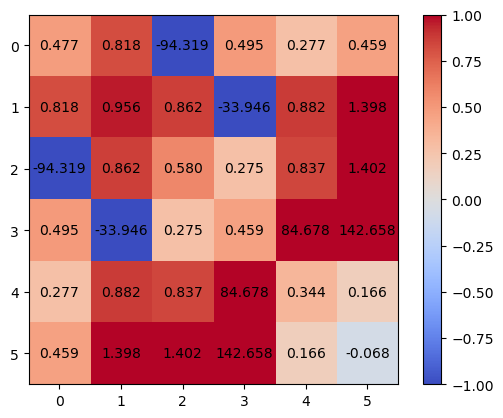

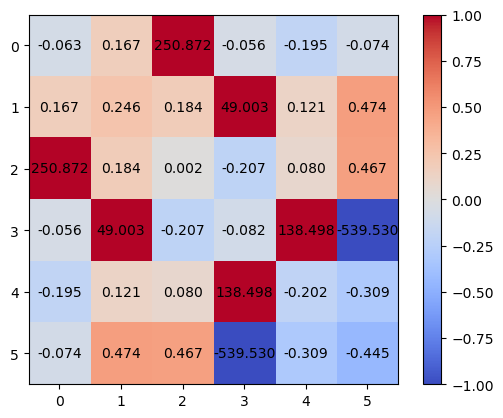

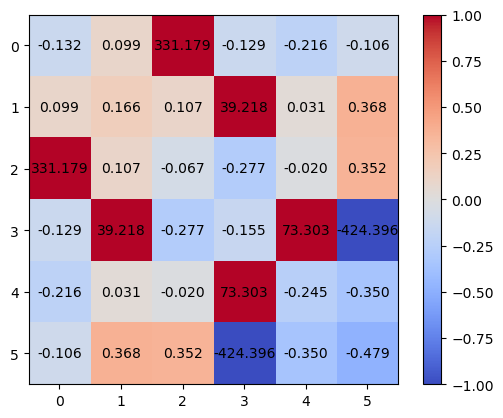

In [22]:
vmin = -1
vmax = 1
cov_1e4_50 = get_cov(r_1e4_50, gt_50, relative=True)
plot_cov(cov_1e4_50, vmin=vmin, vmax=vmax)
cov_1e4_95 = get_cov(r_1e4_95, gt_95, relative=True)
plot_cov(cov_1e4_95, vmin=vmin, vmax=vmax)
cov_1e4 = get_cov(r_1e4, gt, relative=True)
plot_cov(cov_1e4, vmin=vmin, vmax=vmax)
print(cov_1e4)
print(cov_1e4_50)
print(cov_1e4_95)
print(get_cov(gt))

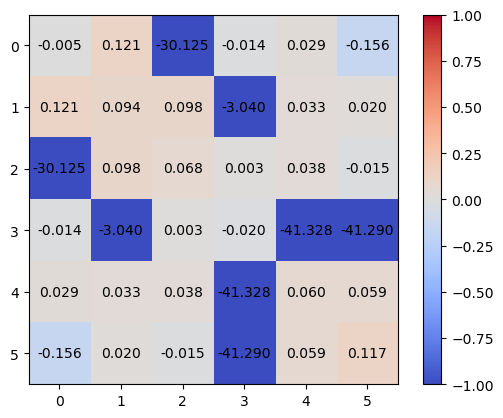

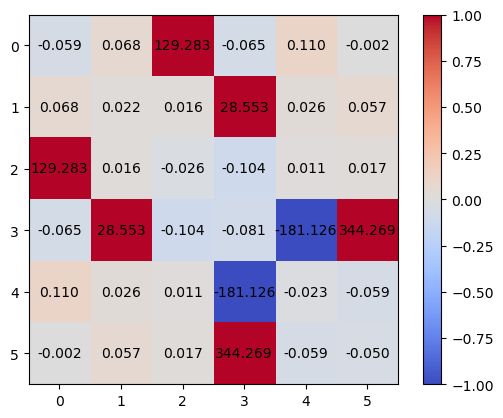

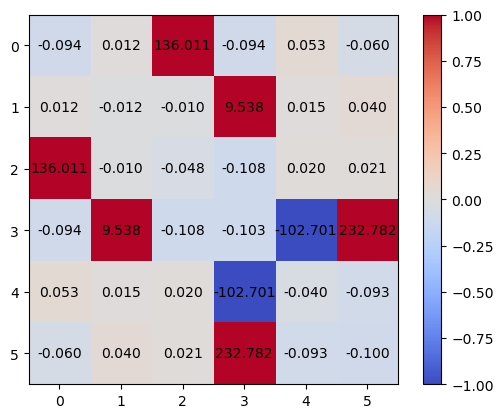

In [23]:
cov_1e5_50 = get_cov(r_1e5_50, gt_50, relative=True)
plot_cov(cov_1e5_50, vmin=vmin, vmax=vmax)
cov_1e5_95 = get_cov(r_1e5_95, gt_95, relative=True)
plot_cov(cov_1e5_95, vmin=vmin, vmax=vmax)
cov_1e5 = get_cov(r_1e5, gt, relative=True)
plot_cov(cov_1e5, vmin=vmin, vmax=vmax)

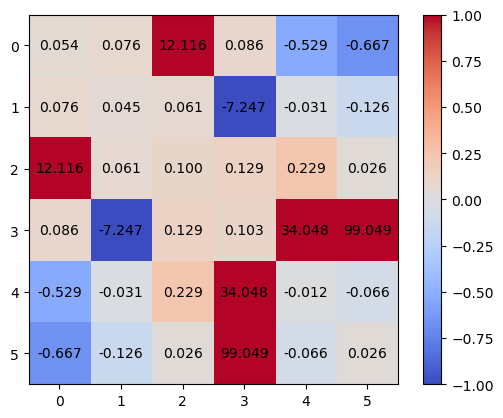

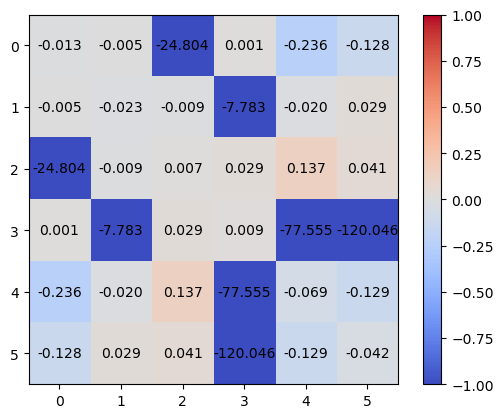

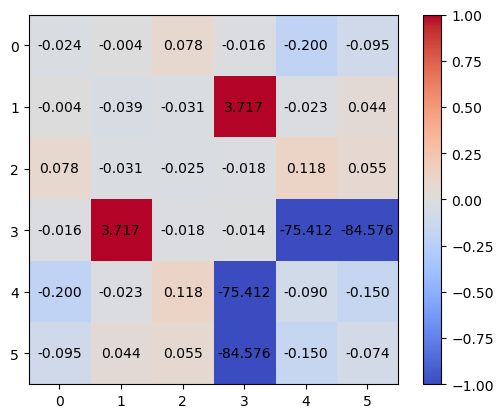

In [24]:
cov_1e6_50 = get_cov(r_1e6_50, gt_50, relative=True)
plot_cov(cov_1e6_50, vmin=vmin, vmax=vmax)
cov_1e6_95 = get_cov(r_1e6_95, gt_95, relative=True)
plot_cov(cov_1e6_95, vmin=vmin, vmax=vmax)
cov_1e6 = get_cov(r_1e6, gt, relative=True)
plot_cov(cov_1e6, vmin=vmin, vmax=vmax)

In [25]:
print(get_cov(gt_50))
print(get_cov(gt_95))
print(get_cov(gt))

[[10.064 -2.787 -0.016 -4.846 -0.489 -5.647]
 [-2.787 3.231 -4.849 -0.004 0.547 6.311]
 [-0.016 -4.849 10.091 2.807 -0.853 -9.849]
 [-4.846 -0.004 2.807 3.235 -0.002 -0.017]
 [-0.489 0.547 -0.853 -0.002 0.511 5.893]
 [-5.647 6.311 -9.849 -0.017 5.893 79.838]]
[[16.535 -4.595 0.007 -7.955 -0.806 -9.306]
 [-4.595 5.307 -7.952 0.004 0.897 10.334]
 [0.007 -7.952 16.523 4.584 -1.398 -16.106]
 [-7.955 0.004 4.584 5.306 -0.001 0.004]
 [-0.806 0.897 -1.398 -0.001 0.839 9.674]
 [-9.306 10.334 -16.106 0.004 9.674 131.122]]
[[18.010 -5.005 0.006 -8.665 -0.877 -10.131]
 [-5.005 5.779 -8.657 0.006 0.976 11.249]
 [0.006 -8.657 17.990 4.991 -1.523 -17.536]
 [-8.665 0.006 4.991 5.778 -0.001 0.005]
 [-0.877 0.976 -1.523 -0.001 0.913 10.525]
 [-10.131 11.249 -17.536 0.005 10.525 142.652]]
